In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

e:\Installation\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Installation\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
index_of_hospital_for_prediction = 13

In [3]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

dfs = []

# loop through all files in the folder and read them and append them to the list

for file in glob.glob('../../Data/Processed data/*.xlsx'):
    print(file)
    df = read_excel(file)
    dfs.append(df)


../../Data/Processed data\250 shojja.xlsx
../../Data/Processed data\31 shojja.xlsx
../../Data/Processed data\ad-din.xlsx
../../Data/Processed data\aichi.xlsx
../../Data/Processed data\Al manar.xlsx
../../Data/Processed data\Anowar khan.xlsx
../../Data/Processed data\azgol ali.xlsx
../../Data/Processed data\Delta medical.xlsx
../../Data/Processed data\Dhaka central.xlsx
../../Data/Processed data\dmd central.xlsx
../../Data/Processed data\h&h.xlsx
../../Data/Processed data\hfrc.xlsx
../../Data/Processed data\ibn sina.xlsx
../../Data/Processed data\islami bank.xlsx
../../Data/Processed data\lstm_dmc.xlsx
../../Data/Processed data\Medical college for women.xlsx
../../Data/Processed data\Metropoliton medical.xlsx
../../Data/Processed data\police hospital.xlsx
../../Data/Processed data\popular medical.xlsx
../../Data/Processed data\Sajeda hospital.xlsx
../../Data/Processed data\shomorita.xlsx
../../Data/Processed data\Square.xlsx
../../Data/Processed data\ssmc.xlsx
../../Data/Processed data\

In [4]:
coordinates = [(23.78023378522258, 90.36734693327269),
               (23.717878894611427, 90.37687614386095),
               (23.74854258987857, 90.4054805619277),
               (23.881790066203926, 90.40410896582604),
               (23.756052674223117, 90.36321845418024),
               (23.74530536688184, 90.38222402534431),
               (23.70789594683928, 90.42361642349367),
               (23.788602125062823, 90.35348610815265),
               (23.743909512744548, 90.38430874415275),
               (23.751892721210428, 90.38546900815183),
               (23.74692774941598, 90.40312845418005),
               (23.752132125860218, 90.41353537340008),
               (23.73972361480249, 90.4206285118513),
               (23.726327283426574, 90.39766652719375),
               (23.858439631417777, 90.40093773883972),
               (23.858439631417777, 90.40089482349694),
               (23.736396173493542, 90.41672412478748),
               (23.739433993904264, 90.38224623884184),
               (23.753565317444227, 90.3852717198413),
               (23.752951798763714, 90.38150615233585),
               (23.710654780247634, 90.40201004780278),
               (23.804802336161362, 90.41579431185583),
               (23.77636504355202, 90.39571531185526),
               (23.87475779737836, 90.39663462350299)
               ]

In [5]:
len(dfs)

26

In [6]:
# size of coordinates
len(coordinates)

24

In [7]:
def preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].values.astype(float)
    #sort by date
    df = df.sort_values(by='Date')
    # for rows where df['Affected'] is null or non-numeric, replace with 0
    df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
    df.reset_index(drop=True, inplace=True)
    return df

In [8]:
i=1

for df in dfs:
    print(str(i))
    df = preprocess(df)
    print("done ")
    i+=1

1
done 
2
done 
3
done 
4
done 
5
done 
6
done 
7
done 
8
done 
9
done 
10
done 
11
done 
12
done 
13
done 
14
done 
15
done 
16
done 
17
done 
18
done 
19
done 
20
done 
21


done 
22
done 
23
done 
24
done 
25
done 
26
done 


In [9]:
# find distance between two coordinates
def distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

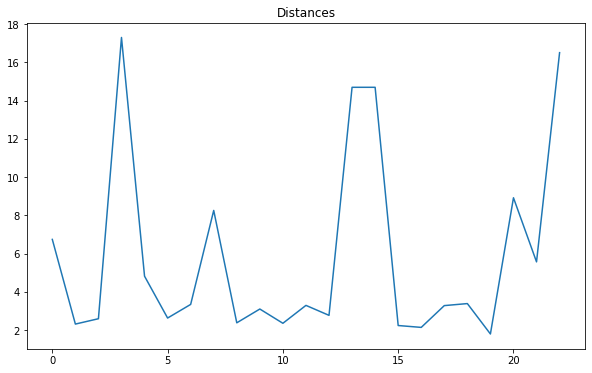

In [10]:
distances_from_other_hospitals = []

#find distances from each hospital to the hospital at index 13 except its own and append to the list
for i in range(len(coordinates)):
    if i != index_of_hospital_for_prediction:
        distances_from_other_hospitals.append(distance(coordinates[index_of_hospital_for_prediction][0], coordinates[index_of_hospital_for_prediction][1], coordinates[i][0], coordinates[i][1]))

#plot the distances
plt.figure(figsize=(10,6))
plt.plot(distances_from_other_hospitals)
plt.title('Distances')
plt.show()


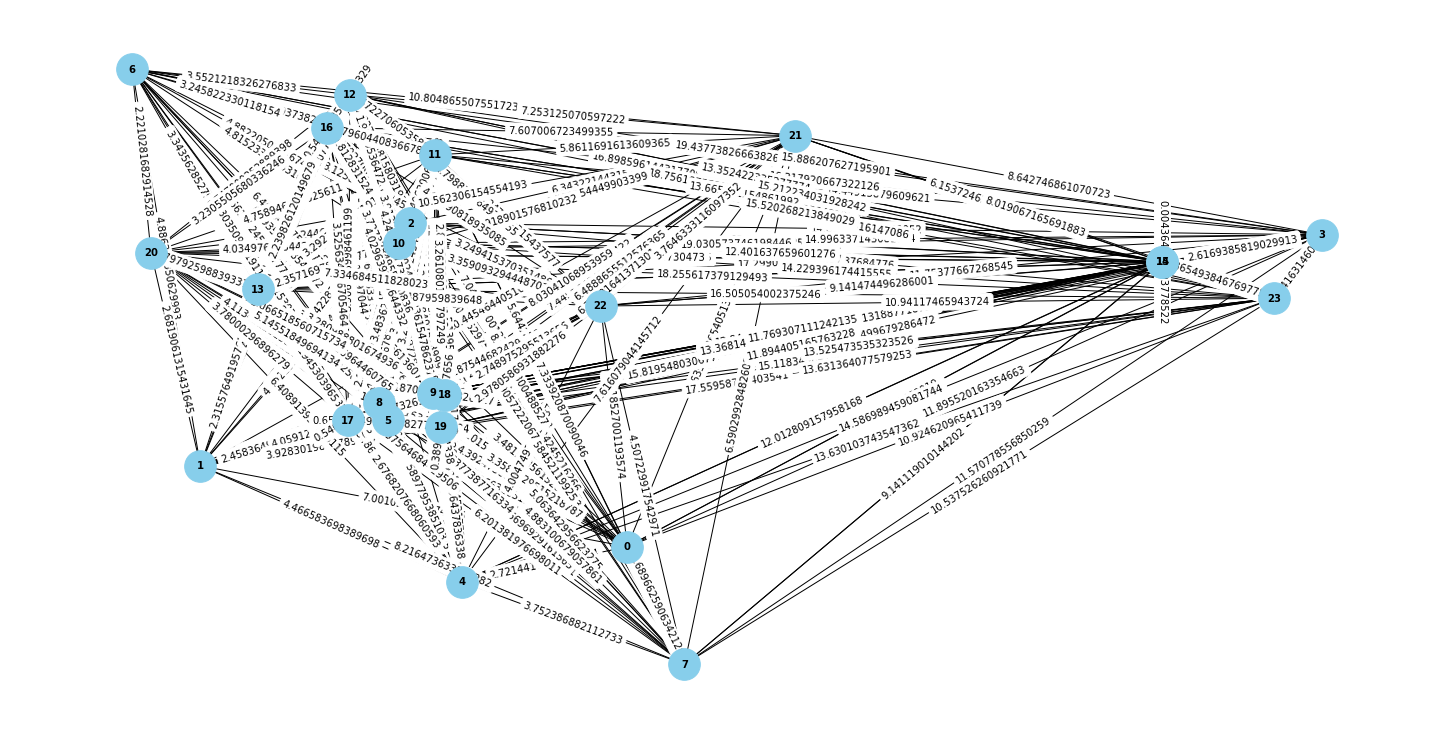

In [11]:
# Make a graph of nodes and edges with weights as distances
import networkx as nx
G = nx.Graph()
for i in range(len(coordinates)):
    G.add_node(i, pos=(coordinates[i][0], coordinates[i][1]))
for i in range(len(coordinates)):
    for j in range(i+1, len(coordinates)):
        G.add_edge(i, j, weight=distance(coordinates[i][0], coordinates[i][1], coordinates[j][0], coordinates[j][1]))

pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(20,10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [12]:
#check if all df in dfs have the same length
for df in dfs:
    print(len(df))


551
551
683
156
156
698
698
698
454
698
698
698
698
698
698
538
156
699
698
156
698
698
699
698
698
698


In [13]:
#check the df size of the hospital at index 13
len(dfs[index_of_hospital_for_prediction])

698

In [14]:
# what is the highest size of the df
max_size = max([len(df) for df in dfs])
max_size

699

In [15]:
# make all the dfs equal size: equal to the size of the hospital with index for prediction
# get the hospital with highest df
# get the index of the hospital with highest df


# for each 'Date' value in the hospital with index for prediction, if other hospitals do not have that 'Date' value, add that 'Date' value to the other hospitals with 'Affected' value as 0
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        for date in dfs[index_of_hospital_for_prediction]['Date']:
            if date not in dfs[i]['Date'].values:
                dfs[i] = pd.concat([dfs[i], pd.DataFrame({'Date': [date], 'Affected': [0]})], ignore_index=True)
        
# If any df has any date value that is not in the hospital with index for prediction, remove that row from the df
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        for date in dfs[i]['Date']:
            if date not in dfs[index_of_hospital_for_prediction]['Date'].values:
                dfs[i] = dfs[i][dfs[i]['Date'] != date]



In [16]:
#now check the size of the dfs again
for df in dfs:
    print(len(df))

698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698
698


In [17]:
# now make a new dataframe where first column is the Affected column of our prediction hospital

data = dfs[index_of_hospital_for_prediction][['Affected']]


In [18]:
data.head()

,Affected
0,1
1,-
2,1
3,1
4,1


In [19]:
# normalize distance values by their weighted average: value/sum

distances_from_other_hospitals = np.array(distances_from_other_hospitals)
distances_from_other_hospitals = distances_from_other_hospitals/np.sum(distances_from_other_hospitals)
distances_from_other_hospitals 

array([0.04988991, 0.0171355 , 0.01920416, 0.12801506, 0.03565834,
       0.01947229, 0.02474271, 0.06109803, 0.01762247, 0.0229554 ,
       0.0174433 , 0.02436674, 0.02051047, 0.10873704, 0.10873632,
       0.01657494, 0.01585043, 0.02427965, 0.02506257, 0.01330484,
       0.06600078, 0.04119998, 0.12213908])

In [20]:
# now subtract each value from 1
distances_from_other_hospitals = 1 - distances_from_other_hospitals
distances_from_other_hospitals

array([0.95011009, 0.9828645 , 0.98079584, 0.87198494, 0.96434166,
       0.98052771, 0.97525729, 0.93890197, 0.98237753, 0.9770446 ,
       0.9825567 , 0.97563326, 0.97948953, 0.89126296, 0.89126368,
       0.98342506, 0.98414957, 0.97572035, 0.97493743, 0.98669516,
       0.93399922, 0.95880002, 0.87786092])

In [21]:
# agian get the weighted average
distances_from_other_hospitals = distances_from_other_hospitals/np.sum(distances_from_other_hospitals)
distances_from_other_hospitals

array([0.04318682, 0.04467566, 0.04458163, 0.03963568, 0.04383371,
       0.04456944, 0.04432988, 0.04267736, 0.04465352, 0.04441112,
       0.04466167, 0.04434697, 0.04452225, 0.04051195, 0.04051199,
       0.04470114, 0.04473407, 0.04435092, 0.04431534, 0.04484978,
       0.04245451, 0.04358182, 0.03990277])

In [22]:
# now add columns for each hospital in the data dataframe
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        data['Hospital_'+str(i)] = dfs[i]['Affected']

data.head()

,Affected,Hospital_0,Hospital_1,Hospital_2,Hospital_3,Hospital_4,Hospital_5,Hospital_6,Hospital_7,Hospital_8,...,Hospital_16,Hospital_17,Hospital_18,Hospital_19,Hospital_20,Hospital_21,Hospital_22,Hospital_23,Hospital_24,Hospital_25
0,1,-,-,0,6.0,13.0,-,-,-,0.0,...,1.0,-,-,7.0,-,1,-,-,-,2
1,-,-,-,0,13.0,8.0,-,-,1,0.0,...,0.0,-,-,4.0,-,1,4,-,1,1
2,1,-,-,0,13.0,18.0,-,2,-,1.0,...,2.0,-,-,7.0,-,-,-,-,1,1
3,1,-,-,0,14.0,14.0,-,-,-,0.0,...,2.0,-,-,9.0,-,-,-,-,-,-
4,1,-,-,0,17.0,15.0,-,1,-,2.0,...,0.0,-,-,0.0,-,-,-,-,1,-


In [23]:
# if any cell is null or contains non-numeric value, replace with 0
data = data.fillna(0)
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)
data.head()



,Affected,Hospital_0,Hospital_1,Hospital_2,Hospital_3,Hospital_4,Hospital_5,Hospital_6,Hospital_7,Hospital_8,...,Hospital_16,Hospital_17,Hospital_18,Hospital_19,Hospital_20,Hospital_21,Hospital_22,Hospital_23,Hospital_24,Hospital_25
0,1.0,0.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,13.0,8.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,1.0,4.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,13.0,18.0,0.0,2.0,0.0,1.0,...,2.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,14.0,14.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,17.0,15.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# nultiplying each column with the corresponding distance value
j = 0
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        for k in range(len(data)):
            data['Hospital_'+str(i)][k] = float(data['Hospital_'+str(i)][k]) * distances_from_other_hospitals[j]
        j+=1

data.head()

IndexError: index 23 is out of bounds for axis 0 with size 23

In [ ]:
# now sum all the columns from  hospital 0 to last to get the final value
data['From other hospitals'] = data.iloc[:, 1:].sum(axis=1)
data.head()

,Affected,Hospital_0,Hospital_1,Hospital_2,Hospital_3,Hospital_4,Hospital_5,Hospital_6,Hospital_7,Hospital_8,...,Hospital_15,Hospital_16,Hospital_17,Hospital_18,Hospital_19,Hospital_20,Hospital_21,Hospital_22,Hospital_23,From other hospitals
0,92.0,0.0,0.0,0.0,0.237814,0.569838,0.0,0.00000,0.000000,0.000000,...,0.040512,0.0,0.0,0.0,0.044315,0.000000,0.0,0.000000,0.079806,1.061154
1,82.0,0.0,0.0,0.0,0.515264,0.350670,0.0,0.00000,0.042677,0.000000,...,0.000000,0.0,0.0,0.0,0.044315,0.179399,0.0,0.043582,0.039903,1.215810
2,64.0,0.0,0.0,0.0,0.515264,0.789007,0.0,0.08866,0.000000,0.044654,...,0.081024,0.0,0.0,0.0,0.000000,0.000000,0.0,0.043582,0.039903,1.690962
3,47.0,0.0,0.0,0.0,0.554900,0.613672,0.0,0.00000,0.000000,0.000000,...,0.081024,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.249595
4,63.0,0.0,0.0,0.0,0.673807,0.657506,0.0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.331312


In [ ]:
# drop all the column except 'Affected' and 'From other hospitals'
data = data[['Affected', 'From other hospitals']]
data.head()

,Affected,From other hospitals
0,92.0,1.061154
1,82.0,1.215810
2,64.0,1.690962
3,47.0,1.249595
4,63.0,1.331312


In [ ]:
# make a new dataframe where each row of 'data' dataframe makes up two rows of the new dataframe, first row for 'Affected' and second row for 'From other hospitals'. so the new dataframe hase only one column
new_data = pd.DataFrame(columns=['Value'])
for i in range(len(data)):
    new_data = pd.concat([new_data, pd.DataFrame({'Value': [data['Affected'][i]]})], ignore_index=True)
    new_data = pd.concat([new_data, pd.DataFrame({'Value': [data['From other hospitals'][i]]})], ignore_index=True)

new_data.head()


C:\Users\aniki\AppData\Local\Temp/ipykernel_22760/1814953727.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_data = pd.concat([new_data, pd.DataFrame({'Value': [data['Affected'][i]]})], ignore_index=True)


,Value
0,92.000000
1,1.061154
2,82.000000
3,1.215810
4,64.000000


In [ ]:
new_data.shape

(1396, 1)

In [ ]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
input_size = 14
prediction_window = 3
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  17  input_size:  14  num_layers:  1


In [ ]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(new_data, window_size)

In [ ]:
samples[0]

,Value
0,92.000000
1,1.061154
2,82.000000
3,1.215810
4,64.000000
5,1.690962
6,47.000000
7,1.249595
8,63.000000
9,1.331312


In [ ]:
len(samples)

1380

In [ ]:
new_df = pd.DataFrame([sample['Value'].values for sample in samples])
new_df = new_df.transpose()
new_df.columns = [f'Value_{i}' for i in range(len(samples))]
new_df = new_df.transpose()
new_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Value_0,92.000000,1.061154,82.000000,1.215810,64.000000,1.690962,47.000000,1.249595,63.000000,1.331312,61.000000,0.000000,33.000000,1.485346,52.000000,1.316791,81.000000
Value_1,1.061154,82.000000,1.215810,64.000000,1.690962,47.000000,1.249595,63.000000,1.331312,61.000000,0.000000,33.000000,1.485346,52.000000,1.316791,81.000000,1.197884
Value_2,82.000000,1.215810,64.000000,1.690962,47.000000,1.249595,63.000000,1.331312,61.000000,0.000000,33.000000,1.485346,52.000000,1.316791,81.000000,1.197884,49.000000
Value_3,1.215810,64.000000,1.690962,47.000000,1.249595,63.000000,1.331312,61.000000,0.000000,33.000000,1.485346,52.000000,1.316791,81.000000,1.197884,49.000000,1.049848
Value_4,64.000000,1.690962,47.000000,1.249595,63.000000,1.331312,61.000000,0.000000,33.000000,1.485346,52.000000,1.316791,81.000000,1.197884,49.000000,1.049848,51.000000


In [ ]:
#delte each 2nd row
new_df = new_df.iloc[::2]

In [ ]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Value_0,92.0,1.061154,82.0,1.215810,64.0,1.690962,47.0,1.249595,63.0,1.331312,61.0,0.000000,33.0,1.485346,52.0,1.316791,81.0
Value_2,82.0,1.215810,64.0,1.690962,47.0,1.249595,63.0,1.331312,61.0,0.000000,33.0,1.485346,52.0,1.316791,81.0,1.197884,49.0
Value_4,64.0,1.690962,47.0,1.249595,63.0,1.331312,61.0,0.000000,33.0,1.485346,52.0,1.316791,81.0,1.197884,49.0,1.049848,51.0
Value_6,47.0,1.249595,63.0,1.331312,61.0,0.000000,33.0,1.485346,52.0,1.316791,81.0,1.197884,49.0,1.049848,51.0,0.843966,40.0
Value_8,63.0,1.331312,61.0,0.000000,33.0,1.485346,52.0,1.316791,81.0,1.197884,49.0,1.049848,51.0,0.843966,40.0,0.634171,34.0


In [ ]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(new_df, 0.8, True)

In [ ]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [ ]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape)

X_train.shape:  (552, 14)  y_train.shape:  (552, 3)  X_test.shape:  (138, 14)  y_test.shape:  (138, 3)


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#introduce a GAT (graph attention network) model

class GAT(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GAT, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.layers = nn.ModuleList([self.create_layer() for _ in range(num_layers)])
        self.out = nn.Linear(hidden_size, prediction_window)

    def create_layer(self):
        return nn.Linear(self.input_size, self.hidden_size)

    def forward(self, x):
        for i in range(self.num_layers):
            x = self.layers[i](x)
            x = torch.relu(x)

        x = self.out(x)
        return x

In [ ]:
model = GAT(input_size, hidden_size, num_layers)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)

            loss.backward()

            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch + 1}, Loss: {loss.item()}')

train(model, train_loader, criterion, optimizer, num_epochs)

Epoch: 10, Loss: 72.6968002319336
Epoch: 20, Loss: 73.8116683959961
Epoch: 30, Loss: 165.5026397705078
Epoch: 40, Loss: 48.50204086303711
Epoch: 50, Loss: 247.80738830566406
Epoch: 60, Loss: 30.100473403930664
Epoch: 70, Loss: 208.65431213378906
Epoch: 80, Loss: 120.56417846679688
Epoch: 90, Loss: 92.31729125976562
Epoch: 100, Loss: 33.9809684753418
Epoch: 110, Loss: 111.08910369873047
Epoch: 120, Loss: 50.545833587646484
Epoch: 130, Loss: 35.524471282958984
Epoch: 140, Loss: 36.91134262084961
Epoch: 150, Loss: 87.54407501220703
Epoch: 160, Loss: 47.71592712402344
Epoch: 170, Loss: 22.234453201293945
Epoch: 180, Loss: 54.91963577270508
Epoch: 190, Loss: 57.169769287109375
Epoch: 200, Loss: 96.54498291015625
Epoch: 210, Loss: 61.00260543823242
Epoch: 220, Loss: 26.49388885498047
Epoch: 230, Loss: 54.34103012084961
Epoch: 240, Loss: 68.47989654541016
Epoch: 250, Loss: 169.8809356689453
Epoch: 260, Loss: 8.014788627624512
Epoch: 270, Loss: 3.6825826168060303
Epoch: 280, Loss: 66.973754882

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

Test Loss: 218.5772


In [ ]:
#make the predictions 2 dimensional

predictions = predictions.reshape(-1, prediction_window)

predictions.shape

(138, 3)

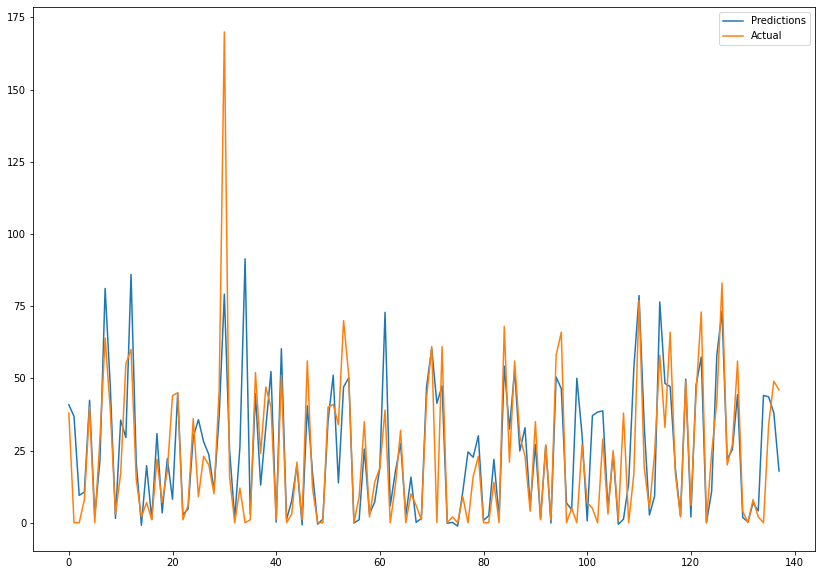

In [ ]:
# as prediction window is 3 and we are predicting 3 days, we will only take the first days of the predictions
prediction = predictions[:, 0]

# get the first column of the y_test
actual = y_test[:, 0]

plt.figure(figsize=(14,10))
plt.plot(prediction, label='Predictions')
plt.plot(actual, label='Actual')
plt.legend()
plt.show()

In [ ]:
# test loss on MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual, prediction)
mse = mean_squared_error(actual, prediction)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')

MAE: 10.39, MSE: 314.69, RMSE: 17.74


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W) # h.shape: (N, in_features), Wh.shape: (N, out_features)
        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        # Wh.shape (N, out_feature)
        # self.a.shape (2 * out_feature, 1)
        # Wh1&2.shape (N, 1)
        # e.shape (N, N)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)

In [ ]:
gat_model = GAT(input_size, hidden_size, prediction_window, 0.6, 0.2, 8)

criterion = nn.MSELoss()

optimizer = optim.Adam(gat_model.parameters(), lr=learning_rate)

In [ ]:
from torch.autograd import Variable

adj = torch.ones((input_size, input_size)) 

def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            y_pred = model(X_batch, adj)

            loss = criterion(y_pred, y_batch)

            loss.backward()

            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch + 1}, Loss: {loss.item()}')

train(gat_model, train_loader, criterion, optimizer, num_epochs)

RuntimeError: The size of tensor a (14) must match the size of tensor b (32) at non-singleton dimension 1